2022-01-03:08:17:37, INFO     [AZernike.py:0478] GPU Available RAM: 3.458 GB


Current Time = 08:17:37

************************************************************
use_gpu = 1, use_hash=1

************************************************************
rho theta
rho shape = (4000000,)
img shape=  (512, 512)
img shape=  (2000, 2000)
************************************************************
K = 2.0, T = 5

Plotting .... 
use_gpu = 1, use_hash=1, use_thread = 0


2022-01-03:08:17:39, INFO     [AZernike.py:0478] GPU Available RAM: 3.456 GB


rho shape = (9000000,)
img shape=  (512, 512)
img shape=  (3000, 3000)
************************************************************
K = 3.0, T = 5

Plotting .... 
use_gpu = 1, use_hash=1, use_thread = 0


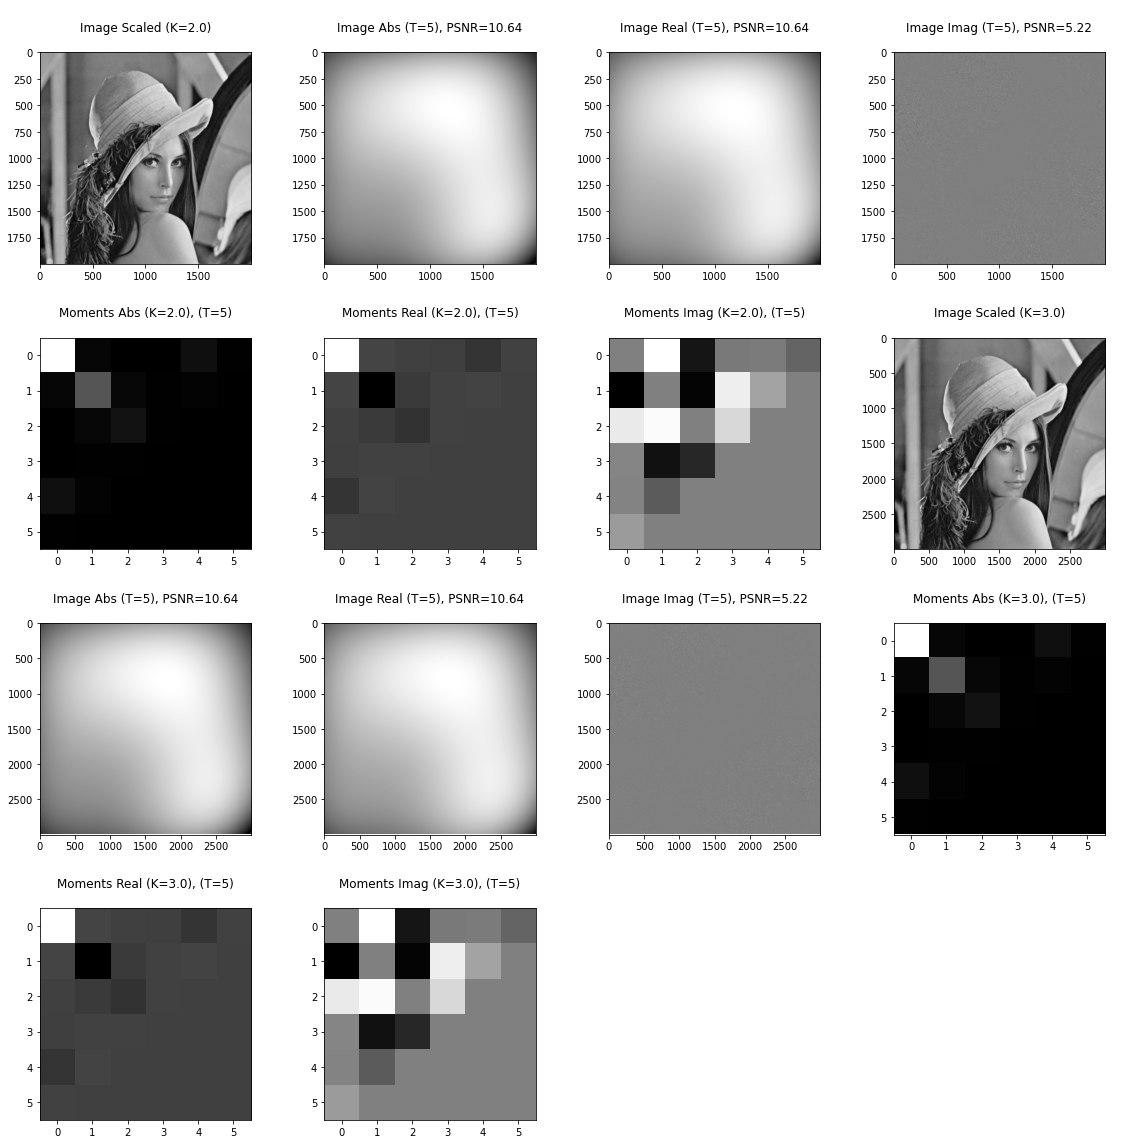


Done.
Wall time: 9.18 s


In [26]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

def pq_list( T ) :
    pqs = []

    for p in range( 0, T + 1 ) : 
        for q in range( -p, p + 1, 2 ) :
            pqs.append( [p, q] )        
        pass
    pass

    return pqs
pass # pq_list

def get_option( key, default = 0 , ** options ) : 
    if key in options :
        return options[ key]
    else :
        return default 
    pass
pass # get_option

def get_core_count(**options) : 
    use_thread = get_option( "use_thread", **options )
    use_gpu = get_option( "use_gpu", **options ) 
    
    core_count = 0 
    
    if not use_thread :
        core_count =  0 
    else :
        if use_gpu :
            core_count = len( GPUtil.getGPUs() )
        else :
            core_count = psutil.cpu_count(logical=True)
        pass
    pass

    log.info( f"core_count = {core_count}, gpu = {use_gpu}, thread = {use_thread}")

    return core_count
pass
    
def calc_moments( T, img, rho, theta, dx, dy , **options ) : 
    then = perf_counter()
        
    use_thread = get_option( "use_thread", **options )
    use_gpu = get_option( "use_gpu", **options ) 
    
    s = T 
    moments = np.zeros( (s + 1, 2*s + 1), np.complex_ )

    img_flat = img.flatten()

    pqs = pq_list( T )
    
    for p, q in pqs :
        v_pq = Vpq( p, q, rho, theta, **options )
        v_pq = np.conjugate( v_pq )
        
        #print( f"v_pq size = {v_pq.size}" )
        #print( f"img_flat size = {img_flat.size}" )
        
        moment = np.dot( v_pq, img_flat )*dx*dy
        
        moments[ p, q ] = moment
        
        #print( f"moment({p:2d}, {q:3d}) = ", moment )
    pass

    if 0 :
        print( "Moments = ", moments )
    pass

    run_time = perf_counter() - then

    return moments, run_time
pass # calc_moments

def restore_image(moments, rho, theta, **options) : 
    then = perf_counter()
    
    np = cupy if options["use_gpu"] else numpy
    
    s = T = moments.shape[0] - 1 
    
    img = np.zeros_like( rho, np.complex_ )
    
    pqs = pq_list( T )
    
    area = 2 # outer type image area in unit_circle
    if "circle_type" in options and "inner" in options["circle_type"] :
        area = pi
    pass        
    
    for p, q in pqs :
        v_pq = Vpq( p, q, rho, theta, ** options )
        img += ((p+1)/area)*moments[p, q]*v_pq
    pass 

    s = int( math.sqrt( len( img ) ) )
    
    img = img.reshape( s, s )
    
    run_time = perf_counter() - then
    
    return img , run_time
pass ## restore_image

def calc_psnr(img_org, img_restored) : 
    img_diff = img_org - img_restored

    #gmax = np.max( img_restored ) # 복원된 이미지의 회색조 최대값 
    gmax = 255

    mse = np.sum( np.square( img_diff ) )/(img_diff.shape[0]*img_diff.shape[1])

    psnr = 10*math.log10(gmax*gmax/mse)
    
    return psnr
pass # calc_psnr

def get_moments_disp(moments) :
    T = moments.shape[0] - 1
    s = T + 1 
    
    moments_disp = np.zeros( (s, s), np.complex_ )
    
    for p in range( 0, T + 1 ) :
        r = p
        c = 0 
        for q in range( -p, p + 1, 2 ) :
            #print( f"p = {p}, q = {q}, r = {r}, c = {c}" )
            
            moments_disp[ r, c ] = moments[ p, q ]
            
            r = r - 1
            c = c + 1            
        pass
    
        #print()
    pass

    #moments_disp = moments_disp*127.5 + 127.5
    
    return moments_disp    
pass # get_moments_disp

# 차수에 따른 연산 속도 

print_curr_time()

line = "*"*60
line2 = "\n" + line

options = {}
options[ "debug" ] = 0 
options[ "use_gpu" ] = 1
options[ "hash" ] = {}
options[ "use_hash" ] = 1  
options[ "use_thread"] = 0 

print( line2 )
print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }" )

print( line2 )
print( "rho theta")

circle_type = "outer"

img_infos = []
    
Ks = numpy.arange( 2, 3.1, 1 ) 

for K in Ks : 
    if "hash" in options : 
        del options[ "hash" ]
    pass

    options[ "hash" ] = {}

    rho, theta, x, y, dx, dy, k = rho_theta( 1000*K, circle_type, **options ) 

    print( f"rho shape = {rho.shape}" )

    img = cv.imread( 'image/lenna.png', 0 )

    print( "img shape= ", img.shape )

    img_org = img 

    np = cupy if options['use_gpu'] else numpy

    img = cv.resize( img_org, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )

    if options['use_gpu']  : 
        img = np.array( img )
    pass

    img_org = img

    print( "img shape= ", img.shape )

    print( line )

    T_MAX = 25 

    max_mem = max_gpu_memory() if options['use_gpu']  else max_cpu_memory() 

    if max_mem < 8 :
        T_MAX = 18
    elif max_mem < 25 :
        T_MAX = 20
    pass

    T_MAX = 5 

    T = T_MAX
    print( f"K = {K}, T = {T}" )

    moments, run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
    img_restored, run_time2 = restore_image(moments, rho, theta, **options )
    
    print( "\nPlotting .... ")
    print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }, use_thread = { options['use_thread'] }" )

    img_infos.append( { "title" : f"Image Scaled (K={K})", "img" : img } )
    
    t_img = np.absolute( img_restored )
    img_infos.append( { "title" : f"Image Abs (T={T})", "img" : t_img, "psnr" : calc_psnr( img_org, t_img )  } )
    
    t_img = img_restored.real
    img_infos.append( { "title" : f"Image Real (T={T})", "img" : t_img, "psnr" : calc_psnr( img_org, t_img ) } )
    
    t_img = img_restored.imag
    img_infos.append( { "title" : f"Image Imag (T={T})", "img" : t_img, "psnr" : calc_psnr( img_org, t_img ) } )

    moments_disp = get_moments_disp( moments )
    img_infos.append( { "title" : f"Moments Abs (K={K})", "img" : np.absolute( moments_disp.real ), "colorbar" : 0 } )
    img_infos.append( { "title" : f"Moments Real (K={K})", "img" : moments_disp.real, "colorbar" : 0 } )
    img_infos.append( { "title" : f"Moments Imag (K={K})", "img" : moments_disp.imag, "colorbar" : 0 } ) 
pass

# 서브 챠트 생성 
col_cnt = 4
row_cnt = len( img_infos ) // col_cnt
if col_cnt*row_cnt < len( img_infos ) :
    row_cnt += 1
pass

fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(4*col_cnt, 4*row_cnt) )
charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 

for img_info in img_infos : 
    t_img = img_info[ "img" ]
    title = img_info[ "title" ]
    title_low = title.lower()
    
    if "psnr" in img_info : 
        psnr = img_info[ "psnr"]
        
        title = f"\n{title}, PSNR={psnr:.2f}\n"
    elif "moment" in title_low :
        title = f"\n{title}, (T={T})\n"
    else :
        title = f"\n{title}\n"
    pass
        
    colorbar = False 
    if "colorbar" in img_info :
        colorbar = img_info[ "colorbar" ]

    chart = charts[ chart_idx ] ; chart_idx += 1
    
    chart.set_title( title )
    
    pos = chart.imshow( cupy.asnumpy( t_img ) if options["use_gpu"] else t_img, cmap='gray' )
    colorbar and fig.colorbar(pos, ax=chart)
pass

# draw empty chart
for chart_idx in range( chart_idx, len(charts) ) :
    chart = charts[ chart_idx ]
    chart.plot( [0,0], [0,0] )
    chart.set_axis_off()
pass

plt.tight_layout(); plt.show() 

del options

print( "\nDone." )